In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Imports

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# utilities
import utilities
from datetime import date
from datetime import timedelta
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, ShuffleSplit

In [4]:
# model imports
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,RidgeClassifier,SGDClassifier,Perceptron
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,NuSVC,LinearSVC

In [5]:
# model imports
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Executive summary

#### Introduction
This report was comissioned to analyze and model interest in the gym memberships offered by our client in the Polish market. As such this work attempts to answer the question: who should the company target in the Polish market? The analysis has been based on various socio-demographic factors like age,sex,occupation etc. as well as the location data, with a final goal maximizing the efficiency of the gym chain's marketing actions by targeting the most interested groups of people. 

#### Findings
In the course of the analysis of the data several trends have been identified, the most important being:
* Young people (around 20 to 30 years old) show higher interest in gym memberships than older people
* Residents of large cities are more interested in exercising
* People with average number of friends show higher propensity towards gym memberships than people with number significantly below or above the average
* Men are more likely to buy a gym membership than women
* People doing physical work or affiliated to military are more likely to show interest in attending gym
* Office workers are much less likely to go to the gym
* Single people are much more likely to be interested in gym memberships, compared to other relationship statuses
* Belonging to the sport themed groups is a very strong indicator of gym interest
* Similarly, having sport related hobbies also points towards higher interest in gym memberships
* Level of education has no significant influence on gym interest

Based on these finding we can conclude, that to achieve the highest income while minimizing the cost, the company should target young single men living in the large Polish cities like Warsaw, Kraków or Lodz that belong to sport groups and have sport related hobbies. That group shows the highest inclination towards gym and the interest in gym memberships in that group should be much higher than the 20% observed in the whole dataset.

#### Machine learning model
The second objective of this report was to create a machine learning model that could predict based on the provided data whether a person will show interest in buying a gym membership. For that purpose various models have been examined with the final model achieving the 0.8 value of f1 score. The final model is an ensemble of 5 models that have been chosen based on their separate performance.

#### Limitations
One of the biggest limitations was the small amount of data. The training set contained only 4000 records, meaning that the possibility of achieving high accuracy has been limited. Small amount of data has been especially problematic with the features with high cardinality like the location data. Because of the large amount of locations compared to the total amount of data, many locations were very sparsely represented. Because of that, it was hard to establish the real amount of interest in gym memberships in these locations. Another significant limitation was lack of powerful enough hardware to run more sophisticated models. The most relevant interest groups have been identified based on their correlation with the target variable but that approach omitted some relevant groups that perhaps separately were sparsely represented but could have been useful when summed up. To improve the group detection, a Natural Language Processing clustering could be utilized. Such approach however needs better hardware. Another limitation was lack of context of the data. It is not known how this data was collected, therefore it was more complex to fill the missing values, not knowing their origin.

# Load csv data

In [6]:
# Structured data
train_csv = pd.read_csv('data/train.csv')
test_csv = pd.read_csv('data/test.csv')

In [7]:
train_csv.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type
0,0,1,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa
1,1,0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN
2,2,1,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN
3,3,0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa
4,4,0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN


## Data description

* user_id: numerical, discrete feature, unique for each row, not useful for modelling
* target: categorical binary feature, target variable indicating interest in gym memberships
* name: textual feature, name of a person, could be used for predicting sex
* sex: categorical binary feature indicating person's sex
* dob: textual feature indicating the date of birth, should be transformed into timestamps
* location: categorical data with high cardinality (731 categories) indicating the person's location in Poland, one hot encoding not advisable, should be transformed into a different form or grouped 
* location_population: numerical, discrete feature indicating the population of the person's location
* location_from: categorical data with high cardinality (732 categories) indicating the person's location in Poland, one hot encoding not advisable, should be transformed into a different form or grouped 
* location_from_population: numerical, discrete feature indicating the population of the person's location
* occupation: categorical data indicating person's job, relatively high cardinality, 43 categories, should be transformed into a more useful form
* hobbies: textual data indicating person's hobbies, needs to be transformed into categorical features
* daily_commute: numerical, continuous feature showing the length of person's daily commute
* friends_number: numerical, discrete feature showing the number of friends a person has 
* relationship_status: categorical data with 5 categories indicating the status of the relationship, should be one hot encoded
* education: categorical ordinal feature, from 1 to 6, higher number indicates higher level of education
* credit_card_type: categorical feature with 4 categories, indicating type of credit card, should be one hot encoded

# Processing the json data

Data in json format isn't immediately usable like the csv files because it contains nested data which a simple approach cannot process correctly.

In [8]:
path = 'data/train.json'
train_json = utilities.process_json(path,'groups.data')

In [9]:
path = 'data/test.json'
test_json = utilities.process_json(path,'groups.data')

In [10]:
train_json.head()

,group_name,date_joined,id
0,Let's excercise together and lose a few kilo q...,2008-09-05 09:55:18.730066,0
1,Strongman competition,2008-05-22 21:25:22.572365,0
2,Fast food 4 life,2012-02-02 05:26:01.293628,0
3,alternative medicine - Hypnosis and bioenergot...,2008-07-05 05:47:12.254848,0
4,Tom Cruise group,2009-06-14 16:48:28.606142,1


In [11]:
test_json.head()

,group_name,date_joined,id
0,Wedding planning - places and bands (and other...,2009-03-12 01:01:08.677427,0
1,Harry Potter and the Deathly Hollows,2009-01-15 01:38:06.822220,0
2,"Xbox , Playstation, Wii - console fans",2010-04-02 04:02:58.078934,0
3,Lost&Found (Strzegom),2010-02-01 14:13:34.551920,1
4,"Tennis, Squash, Badminton, table tennis - look...",2008-09-24 17:29:43.356992,1


First step of preprocessing yielded the dataframes containing all the groups with the corresponding IDs of the users and the date they have joined these groups. There is too many of these groups and most of them are not very useful for predicting interest in the gym membership, so in the next step I am going to find which groups have the highest correlation with the target variable.

In [12]:
groups_train = utilities.transform_categories(train_json,'group_name')

In [13]:
groups_train.head()

group_name,2020 elections,Active singles - doing sports together :),Advertising - for creative advertisers and advertisee,Amateur photography,Amphibians and reptiles,Animal rights group - join us if you care!,Animals,Apartments - will rent / looking to rent (Aleksandrów Łódzki),Apartments - will rent / looking to rent (Andrychów),Apartments - will rent / looking to rent (Barcin),...,Work abroad - join to find well paid work and enjoy the experience (Żary),Work abroad - join to find well paid work and enjoy the experience (Żyrardów),World Weightlifting Championships,"Xbox , Playstation, Wii - console fans","Young, fit and healthy - active livestyle = healthy lifestyle.",ZTM Warsaw,alternative medicine - Hypnosis and bioenergotheraphy,ham cooker - recipes,instrumental music - the unheard and undiscovered,"muscle, strength and vascularity - What every bodybuilder should know"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
corr_train = utilities.calculate_correlation(groups_train,train_csv)

In [15]:
corr_train.head()

,Correlation with target
group_name,
"Let's excercise together - gym, bike, climbing wall and other activities",0.182945
Gym,0.173440
Runnning. Advices from profesionals to newbies.,0.170824
Strongman competition,0.170719
Running - global group. Events and news.,0.170696


In [16]:
groups_test = utilities.transform_categories(test_json,'group_name')

In [17]:
groups_test.head()

group_name,2020 elections,Active singles - doing sports together :),Advertising - for creative advertisers and advertisee,Amateur photography,Amphibians and reptiles,Animal rights group - join us if you care!,Animals,Apartments - will rent / looking to rent (Augustów),Apartments - will rent / looking to rent (Bardo),Apartments - will rent / looking to rent (Bartoszyce),...,Work abroad - join to find well paid work and enjoy the experience (Świętochłowice),Work abroad - join to find well paid work and enjoy the experience (Żory),World Weightlifting Championships,"Xbox , Playstation, Wii - console fans","Young, fit and healthy - active livestyle = healthy lifestyle.",ZTM Warsaw,alternative medicine - Hypnosis and bioenergotheraphy,ham cooker - recipes,instrumental music - the unheard and undiscovered,"muscle, strength and vascularity - What every bodybuilder should know"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Based on the train set I was able to select a number of groups that showed the highest correlation with the interest in gym membership. Next I will used that list to select the overlapping groups from the test set to finally add those features to the data obtained from the csv files.

In [18]:
corr_train.head(10)

,Correlation with target
group_name,
"Let's excercise together - gym, bike, climbing wall and other activities",0.182945
Gym,0.173440
Runnning. Advices from profesionals to newbies.,0.170824
Strongman competition,0.170719
Running - global group. Events and news.,0.170696
Fitness and workout anytime,0.166352
"Fitness Singles, Fitness Dates - join us!",0.162138
Gym and motivation,0.159364
"Fitness - largest group in Poland - Events, meeting and knowledge base",0.159266


In [19]:
sport_groups = corr_train.head(100).index

In [20]:
sport_groups = set.intersection(set(groups_test.columns),set(sport_groups))

I decided to pick the top 100 groups with the highest correlation to the target variable. Out of these 100, 66 were also present in the test set so finally those 66 groups were selected.

In [21]:
groups_train = groups_train[sport_groups]
groups_test = groups_test[sport_groups]

In [22]:
groups_test.head()

group_name,"Tennis, Squash, Badminton, table tennis - looking for sparring partner (Warszawa)","Tennis, Squash, Badminton, table tennis - looking for sparring partner (Wrocław)","Fitness - largest group in Poland - Events, meeting and knowledge base",Fitness and workout anytime,Weightlifting - group for amateurs (Kraków),"Young, fit and healthy - active livestyle = healthy lifestyle.",Perfect ABS for summer - still not too late to start working out!,Let's excercise together and lose a few kilo quicker - everyone is welcome! (Warszawa),Arnold Schwarzenegger - shock the muscle!,"Gym - Machines, excercises, diet and anvices",...,"Let's excercise together - gym, bike, climbing wall and other activities",Weightlifting - group for amateurs (Łódź),"muscle, strength and vascularity - What every bodybuilder should know",Weightlifting - group for amateurs (Częstochowa),Let's excercise together and lose a few kilo quicker - everyone is welcome! (Łódź),World Weightlifting Championships,Let's excercise together and lose a few kilo quicker - everyone is welcome! (Poznań),Strongman competition,Mariusz Pudzianowski - fanclub,Gym
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Separate sports groups show relatively low correlation with the interest in gym membership (max at 0.18) mainly because of the small number of people belonging to each one (less than 100) when compared with the total number of users (4000). Therefore, it makes more sense to add up all of the separate group features into one feature.

In [23]:
# all sport groups summed up
print('Total number of people belonging to sport related groups')
group_sum = groups_train.sum(axis=1)
group_sum.value_counts()

Total number of people belonging to sport related groups


0    3101
1     537
2     279
3      60
4      23
dtype: int64

In [24]:
print('Correlation of the summed up group features with the target variable:')
utilities.calculate_correlation(pd.DataFrame(group_sum),train_csv)

Correlation of the summed up group features with the target variable:


,Correlation with target
0,0.677564


After summing up we can see that in total about 20% of people belong to some sports group, out of which about 50% belongs to more than one. Newly created feature is highly correlated with the target value (0.68), so finally, I'll add that feature to the rest of the features from the structured data file.

# Data cleaning and feature engineering

I will concatenate the train and test sets obtained from both the csv and json files before cleaning the data and creating new features so that the same measures are applied to all the data and they continue to come from similar distributions.

In [25]:
ntrain = train_csv.shape[0]
ntest = test_csv.shape[0]
train_test = pd.concat((train_csv,test_csv),axis=0).reset_index(drop=True)
train_test_json = pd.concat((groups_train,groups_test),axis=0).reset_index(drop=True)
group_sum = train_test_json.sum(axis=1)
train_test['sport_groups'] = group_sum 

In [26]:
train_test.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type,sport_groups
0,0,1.0,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa,1
1,1,0.0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN,0
2,2,1.0,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN,0
3,3,0.0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa,0
4,4,0.0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN,0


## Null values

In [27]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   6000 non-null   int64  
 1   target                    4000 non-null   float64
 2   name                      5976 non-null   object 
 3   sex                       5425 non-null   object 
 4   dob                       5415 non-null   object 
 5   location                  6000 non-null   object 
 6   location_population       6000 non-null   int64  
 7   location_from             6000 non-null   object 
 8   location_from_population  6000 non-null   int64  
 9   occupation                6000 non-null   object 
 10  hobbies                   5004 non-null   object 
 11  daily_commute             5391 non-null   float64
 12  friends_number            6000 non-null   int64  
 13  relationship_status       5377 non-null   object 
 14  educatio

Several columns contain missing values so they will have to be filled to procede with the analysis and modelling. First I will process the columns that can be filled relatively easily and the categorical columns so that they I will be able to assess the correlations between available features and therefore see if the other missing values can be imputed from them.

### Sex column

In [28]:
column = 'sex'

In [29]:
utilities.nan_count(train_test,column)

sex
False    5425
True      575
Name: sex, dtype: int64




In order to fill the missing values in the 'sex' column, I'm going to use the textual data about the names of the potential clients. I will check which sex appears most often for a given name and based on that I will asign the sex to the missing values.

In [30]:
unique_names_num = train_test['name'].nunique()
print(f'Number of unique names: {unique_names_num}')

Number of unique names: 205


In [31]:
num_of_names = train_test[['name','sex']].value_counts()

In [32]:
num_of_names = pd.DataFrame(num_of_names).reset_index()

In [33]:
num_of_names

,name,sex,0
0,Franciszek,male,48
1,Daria,female,43
2,Izolda,female,43
3,Eliza,female,43
4,Bożena,female,41
...,...,...,...
200,Aurelian,male,16
201,Amadeusz,male,15
202,Dalia,female,14
203,Gwidon,male,13


There appears to be no ambiguity when it comes to the names and sexes so now I will assign the missing values based on the findings above.

In [34]:
# finding all the male and female names
male_names = set(train_test[train_test['sex']=='male']['name'].dropna())
female_names = set(train_test[train_test['sex']=='female']['name'].dropna())

In [35]:
# extracting the indexes of null values for male and female
male_indexes = train_test[train_test['name'].isin(male_names)]['sex']
male_null_indexes = male_indexes[male_indexes.isnull()].index

female_indexes = train_test[train_test['name'].isin(female_names)]['sex']
female_null_indexes = female_indexes[female_indexes.isnull()].index

In [36]:
# substituting the nulls with correct values
train_test.loc[male_null_indexes,'sex'] = 'male'
train_test.loc[female_null_indexes,'sex'] = 'female'

In [37]:
utilities.nan_count(train_test,column)

sex
False    5997
True        3
Name: sex, dtype: int64




In [38]:
train_test[train_test['sex'].isnull()]

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type,sport_groups
2925,2925,0.0,NaN,NaN,1960-03-30,Warszawa,1764615,Warszawa,1764615,Administrative and commercial managers,"Skiing,Shopping",81.0,166,In relationship,NaN,Visa,0
4551,551,NaN,NaN,NaN,1971-08-24,Puszczykowo,9693,Puszczykowo,9693,Personal care workers,"Stretching,Coloring,Drama,Cycling",NaN,108,Married,5.0,Visa,0
5381,1381,NaN,NaN,NaN,1999-09-10,Warszawa,1764615,Warszawa,1764615,"Building and related trades workers, excluding...","Cardio,Fitness,Archery",17.0,159,Married,2.0,Mastercard,2


There are still rows with missing sex value. Unfortunately, the names are also missing so the previous approach couldn't predict these values. Since there are only 3 such rows, I will fill them by hand based on the occupation, hobbies and the groups to which they belong.

In [39]:
# one person is from the training set
train_json[train_json['id'].isin([2925])]

,group_name,date_joined,id
11781,DIY home renovations - tips& tricks,2009-09-11 22:18:00.469985,2925
11782,Lyceum no. 1 (Warszawa),2011-08-06 19:30:02.494292,2925
11783,Concerts and shows (Warszawa),2009-11-17 18:41:50.149929,2925
11784,Online job market - join us! (Warszawa),2009-11-15 22:41:48.843626,2925


In [40]:
# two people are from the test set
test_json[test_json['id'].isin([551,1381])]

,group_name,date_joined,id
2202,Events and parties (Puszczykowo),2009-07-28 02:23:05.626952,551
2203,Free pizza for everyone!,2008-02-05 17:50:21.027395,551
2204,Online job market - join us! (Puszczykowo),2011-10-04 05:05:28.263672,551
2205,Women's Apparel & Ladies Clothing - second hand,2010-08-01 08:06:06.984667,551
2206,Where to next? Join The Local's,2009-12-17 10:21:28.910293,551
2207,I will take your puppy / want to give away my ...,2010-03-11 20:34:24.681790,551
2208,Easy Sewing for Beginners and Amateurs,2008-08-01 23:10:28.593713,551
5569,WOŚP - Great Orchestra of Christmas Charity,2009-12-07 20:41:44.529754,1381
5570,Rooms for rent (Warszawa),2009-08-07 17:36:07.314821,1381
5571,Advertising - for creative advertisers and adv...,2011-01-22 10:37:17.387782,1381


Based on the group data I will assign people with indexes 2925 and 5381 as male and the one with index 4551 as female.

In [41]:
train_test.at[2925,'sex'] = 'male'
train_test.at[4551,'sex'] = 'female'
train_test.at[5381,'sex'] = 'male'

In [42]:
utilities.nan_count(train_test,column)

sex
False    6000
Name: sex, dtype: int64




Now all of the missing values have been filled in and can be now transformed into numerical encoding (1 for male, 0 for female).

In [43]:
train_test["sex"] = pd.get_dummies(train_test["sex"],drop_first=True)

### Hobbies column

In [44]:
column = 'hobbies'

In [45]:
utilities.nan_count(train_test,column)

hobbies
False    5004
True      996
Name: hobbies, dtype: int64




In [46]:
unique_hobbies_num = train_test[column].nunique()
print(f'Number of unique hobbies: {unique_hobbies_num}')

Number of unique hobbies: 4001


There 996 missing values in the hobbies column. Unfortunately I do not know the context in which this data was collected, but it seems reasonable to assume that perhaps these particular people do not have relevant hobbies, therefore, I will simply fill the missing values with an empty string. The approach that I intend to take with this particular feature also does not require me to fill those values in any other way.

In [47]:
train_test[column].fillna('',inplace=True)

In [48]:
utilities.nan_count(train_test,column)

hobbies
False    6000
Name: hobbies, dtype: int64




Hobbies is a textual feature, but, similarly like the group data from the json file, it can be transformed into categorical data. I will utilize similar approach were I will find the most relevant hobbies in the context of the interest in a gym membership so that I can later check if it can be used to impute other missing values.

In [49]:
# splitting the string with hobby names into lists of hobbies for each user
hobbies_train = train_test[column].loc[:ntrain-1].apply(lambda x: x.strip().lower().split(','))
hobbies_test = train_test[column].loc[ntrain:].apply(lambda x: x.strip().lower().split(',')).reset_index(drop=True)
hobbies_train = pd.DataFrame(hobbies_train)
hobbies_test = pd.DataFrame(hobbies_test)

In [50]:
hobbies_train.head()

,hobbies
0,[fitness]
1,"[larping, foreign language learning, netball]"
2,"[bodybuilding, kabaddi]"
3,[badminton]
4,"[fitness, embroidery, lacemaking]"


In [51]:
# creating a dataframe with all of the hobbies and the corresponding user ids
df_hobbies_train = utilities.append_id(hobbies_train,'hobbies')
df_hobbies_test = utilities.append_id(hobbies_test,'hobbies')

In [52]:
df_hobbies_train.head()

,0,id
0,fitness,0
1,larping,1
2,foreign language learning,1
3,netball,1
4,bodybuilding,2


In [53]:
# transforming the dataframe of hobbies into an encoded dataframe of all hobbies for all user 
# and calculating the correlations with the target
hobbies_train = utilities.transform_categories(df_hobbies_train,0)
corr_hobbies = utilities.calculate_correlation(hobbies_train,train_csv)
hobbies_test = utilities.transform_categories(df_hobbies_test,0)

In [54]:
hobbies_train.head()

,,3d printing,acting,air sports,amateur radio,archery,astronomy,backpacking,badminton,base jumping,...,water sports,web surfing,weightlifting,whittling,wood carving,woodworking,worldbuilding,writing,yo-yoing,yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
hobby_population = pd.DataFrame(hobbies_train.sum())
hobby_population.columns=['sum']
hobby_population.sort_values(by='sum',ascending=False)

,sum
0,
,680
squash,253
bodybuilding,249
gym,249
rowing,229
...,...
gunsmithing,24
mountaineering,24
watching movies,23


In [56]:
corr_hobbies.head(12)

,Correlation with target
0,
cardio,0.152531
squash,0.146000
rowing,0.139118
weightlifting,0.121519
power bike,0.118686
crossfit,0.117781
gym,0.113055
fitness,0.108103
stretching,0.105704


Similarly like in the case of the sports groups, the separate hobbies show relatively low correlation with the interest in gym membership (max at 0.15) mainly because of the small number of people declaring interest in each one of them (maximally 253 declared squash as a hobby) when compared with the total number of users (4000). Therefore once again, it makes more sense to add up all of the separate hobby features into one feature.

In [57]:
# getting the names of the sport related hobbies
sport_hobbies = corr_hobbies.head(12).index

In [58]:
# checking if the hobbies identified in the training set also appear in the test set
sport_hobbies = set.intersection(set(hobbies_test.columns),set(sport_hobbies))

In [59]:
hobbies_train = hobbies_train[sport_hobbies]
hobbies_test = hobbies_test[sport_hobbies]

In [60]:
# concatenating the train and test set
hobbies_train_test = pd.concat((hobbies_train,hobbies_test),axis=0).reset_index(drop=True)

In [61]:
hobbies_train_test.head()

,rowing,bodybuilding,weightlifting,gym,squash,kettleballs,power bike,stretching,crossfit,cardio,badminton,fitness
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,1


In [62]:
hobbies_sum = hobbies_train_test.sum(axis=1)

In [63]:
print('Total number of people with sport related hobbies')
hobbies_sum.value_counts()

Total number of people with sport related hobbies


0    3219
1    1700
2     922
3     158
4       1
dtype: int64

In [64]:
print('Correlation of the summed up hobby features with the target variable:')
utilities.calculate_correlation(pd.DataFrame(hobbies_sum),train_csv)

Correlation of the summed up hobby features with the target variable:


,Correlation with target
0,0.38908


Summing up all of the hobbies has created a new feature that shows significant correlation (0.39) with the interest in gym membership, so that feature will be added to the rest of the columns.

In [65]:
train_test['sport_hobbies'] = hobbies_sum

### Location and location_from columns

In [66]:
cols = ['location','location_from']

In [67]:
for column in cols:
    utilities.nan_count(train_test,column)

location
False    6000
Name: location, dtype: int64


location_from
False    6000
Name: location_from, dtype: int64




In [68]:
print('Number of unique locations:')
train_test[cols].nunique()

Number of unique locations:


location         731
location_from    732
dtype: int64

In [69]:
pd.DataFrame(train_test[cols[0]].value_counts()).describe()

,location
count,731.000000
mean,8.207934
std,26.052013
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,521.000000


In [70]:
pd.DataFrame(train_test[cols[1]].value_counts()).describe()

,location_from
count,732.000000
mean,8.196721
std,24.109749
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,482.000000


Neither of these two columns have any missing values, however since these are categorical columns, they still need to be encoded into a form that is usable for a machine learning model. The problem is that there are too many categories to simply one hot encode them (731 for location and 732 for location_from). Most of these locations appear only once in the whole dataframe though, therefore they wouldn't be of much use for modelling anyway. As such these features can be grouped together or dropped completely without losing much useful information.

In [71]:
# one hot encoding the location and location_from columns
location_encoded = pd.get_dummies(train_test['location'])
location_from_encoded = pd.get_dummies(train_test['location_from'])

Adding 1463 columns to the dataset (most of them very sparse) wouldn't be very useful so for the moment I'll store the encoded locations in separate dataframes for further analysis and feature selection.

Another possible feature that could be useful is whether the person's location and location_from are different. Them being different could suggest longer daily commutes and therefore less time and energy for exercising.

In [72]:
train_test['diff_location'] = pd.get_dummies(train_test['location']==train_test['location_from'],drop_first=True)

### Location population and location_from population

In [73]:
cols = ['location_population','location_from_population']

Location population and location_from population are both continuous numerical features. However, for graphical data analysis and for modelling purposes it may be advantageous to group them into bins. In this case I will group them into small locations (below 200,000 inhabitants), medium (below 500,000 inhabitants) and large locations (above 500,000 inhabitants).

In [74]:
for column in cols:
    utilities.nan_count(train_test,column)

location_population
False    6000
Name: location_population, dtype: int64


location_from_population
False    6000
Name: location_from_population, dtype: int64




Neither of these features have any missing values so I can proceed to grouping them.

In [75]:
population = train_test[cols]

In [76]:
# defining the labels and bin sizes for binning
labels = ['small','medium','large']
bins = [0,  2e+05,  0.5e+06,  1.764615e+06]

In [77]:
location_population_bins, loc_bin_edges = pd.cut(population['location_population'],labels=labels,retbins=True,bins=bins)
location_from_population_bins, loc_from_bin_edges = pd.cut(population['location_from_population'],bins,labels=labels,retbins=True)

In [78]:
train_test['location_population_binned'] = location_population_bins
train_test['location_from_population_binned'] = location_from_population_bins

In [79]:
# one hot encoding the binned columns
loc = pd.get_dummies(train_test['location_population_binned'],prefix='loc')
loc_from = pd.get_dummies(train_test['location_from_population_binned'],prefix='loc_from')

In [80]:
# adding the new columns to the data set
train_test = pd.concat((train_test,loc,loc_from),axis=1)

In [81]:
train_test.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,...,sport_hobbies,diff_location,location_population_binned,location_from_population_binned,loc_small,loc_medium,loc_large,loc_from_small,loc_from_medium,loc_from_large
0,0,1.0,Halina,0,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,...,1,1,small,small,1,0,0,1,0,0
1,1,0.0,Eustachy,1,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,...,0,1,small,small,1,0,0,1,0,0
2,2,1.0,Egon,1,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,...,1,1,small,small,1,0,0,1,0,0
3,3,0.0,Eulalia,0,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,...,1,1,medium,medium,0,1,0,0,1,0
4,4,0.0,Hilary,1,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,...,1,0,small,large,1,0,0,0,0,1


### Occupation column

In [82]:
column = 'occupation'

In [83]:
utilities.nan_count(train_test,column)

occupation
False    6000
Name: occupation, dtype: int64




There are no missing values in the occupation column so I will proceed to processing it for the analysis and modelling. Firstly, I'll utilize the one hot encoding of each category.

In [84]:
unique_occupations = train_test['occupation'].nunique()
job_names = train_test['occupation'].unique()
print(f'There are {unique_occupations} unique occupations in the dataset.')

There are 43 unique occupations in the dataset.


In [85]:
# one hot encoding the occupation column
train_test = pd.concat((train_test,pd.get_dummies(train_test['occupation'])),axis=1)

In [86]:
train_test.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,...,Production and specialised services managers,Protective services workers,Refuse workers and other elementary workers,Sales workers,Science and engineering associate professionals,Science and engineering professionals,Stationary plant and machine operators,Street and related sales and service workers,"Subsistence farmers, fishers, hunters and gatherers",Teaching professionals
0,0,1.0,Halina,0,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,...,0,0,0,0,0,0,0,0,0,1
1,1,0.0,Eustachy,1,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,...,0,0,0,0,0,0,0,0,0,0
2,2,1.0,Egon,1,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,...,0,1,0,0,0,0,0,0,0,0
3,3,0.0,Eulalia,0,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,...,0,0,0,0,0,0,0,0,0,0
4,4,0.0,Hilary,1,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,...,0,0,1,0,0,0,0,0,0,0


In [87]:
# selecting just the one hot encoded occupation columns for analysis and processing
jobs_one_hot_encoded = train_test[job_names]

In [88]:
jobs_one_hot_encoded.sum(axis=0).sort_values(ascending=False)

Food processing, wood working, garment and other craft and related trades workers    159
General and keyboard clerks                                                          157
Refuse workers and other elementary workers                                          154
Business and administration associate professionals                                  153
Information and communications technology professionals                              152
Electrical and electronic trades workers                                             151
Handicraft and printing workers                                                      150
Science and engineering associate professionals                                      149
Legal, social, cultural and related associate professionals                          149
Building and related trades workers, excluding electricians                          149
Production and specialised services managers                                         148
Non-commissioned arme

Each occupation is quite sparsely represented in the dataset, each occupation constitutes only about 2-3% of all the rows of data. Because of that, their impact on modelling will also be limited so it is better to take similar approach like with the groups and hobbies and try to identify jobs that are most (or least) likely to attend gym and sum them together. 

In [89]:
# getting the job names present in the train and test sets
job_names_train = set(train_test['occupation'][:ntrain].values)
job_names_test = set(train_test['occupation'][ntrain:].values)

In [90]:
job_names_train == job_names_test

True

All the jobs from the train set are present in the test set so no need to worry about mismatching the columns

In [91]:
# calculating the correlations between different occupations and the target variable
jobs_by_corr = utilities.calculate_correlation(jobs_one_hot_encoded,train_csv)
# getting the names of the most and least correlated jobs
sport_jobs = jobs_by_corr.head(10).index
not_sport_jobs  = jobs_by_corr.tail(10).index
# selecting the one hot encoded columns for most and least correlated jobs
best_jobs  = jobs_one_hot_encoded[sport_jobs].sum(axis=1)
worst_jobs  = jobs_one_hot_encoded[not_sport_jobs].sum(axis=1)

In [92]:
# concatenating the most and least correlated job columns for correlation calculation
correlated_jobs = pd.DataFrame(pd.concat((best_jobs ,worst_jobs),axis=1))
correlated_jobs.columns = ['Top 10','Bottom 10']

In [93]:
utilities.calculate_correlation(correlated_jobs,train_csv)

,Correlation with target
Top 10,0.062605
Bottom 10,-0.065886


As expected, the jobs with higher interest in sports show positive correlation with target and the ones with lowest, negative. Those correlations are still quite low however so perhaps these features won't be useful predictors.

In [94]:
# adding the newly created features to the dataset
train_test['sport_jobs'] = best_jobs
train_test['non_sport_jobs'] = worst_jobs

### Date of birth column

In [95]:
column = 'dob'

In [96]:
utilities.nan_count(train_test,column)

dob
False    5415
True      585
Name: dob, dtype: int64




There are 585 missing values in the date of birth column. That is much less than the total number of values which is 6000 so these values should be filled in. Predicting the exact birth dates could prove to be complex, but also may be unnecessary. The month or the day of birth are unlikely to be useful features for predicting person's interest in the long-term gym subscription but the year of birth (or more specifically the age) is quite likely to be correlated with the target variable.

In [97]:
example = train_test[column][0]
print(f'Sample from the date of birth column: {example}, data type: {type(example)}')

Sample from the date of birth column: 1982-08-07, data type: <class 'str'>


The data provided is in string format so for processing it has to be converted into a datetime type.

In [98]:
# Provided data is of string type so it has to be transformed into datetime objects
train_test['date_of_birth'] = pd.to_datetime(train_test['dob'], format='%Y-%m-%d')

In [99]:
example = train_test['date_of_birth'][0]
print(f'Sample from the date of birth column: {example}, data type: {type(example)}')

Sample from the date of birth column: 1982-08-07 00:00:00, data type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Now that the data is in a timestamp format I can extract useful information out of it. Realistically the most useful part is the year of birth which will allow me to calculate the age of each person in the dataset.

In [100]:
train_test['year_of_birth'] = train_test['date_of_birth'].dt.year
#train_test['month_of_birth'] = train_test['date_of_birth'].dt.month_name()
#train_test['day_of_birth'] = train_test['date_of_birth'].dt.day

In [101]:
#columns = ['year_of_birth','month_of_birth','day_of_birth']
column = 'year_of_birth'

In [102]:
utilities.nan_count(train_test,column)

year_of_birth
False    5415
True      585
Name: year_of_birth, dtype: int64




In [103]:
# filling the missing values with the median of the year of birth
train_test['year_of_birth'].fillna(train_test['year_of_birth'].median(),inplace=True)

In [104]:
utilities.nan_count(train_test,column)

year_of_birth
False    6000
Name: year_of_birth, dtype: int64




Now that there are no more missing values I will create a new feature: age.

In [105]:
train_test['age'] = 2020-train_test['year_of_birth']

In [106]:
train_test.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,...,Science and engineering professionals,Stationary plant and machine operators,Street and related sales and service workers,"Subsistence farmers, fishers, hunters and gatherers",Teaching professionals,sport_jobs,non_sport_jobs,date_of_birth,year_of_birth,age
0,0,1.0,Halina,0,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,...,0,0,0,0,1,0,0,1982-08-07,1982.0,38.0
1,1,0.0,Eustachy,1,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,...,0,0,0,0,0,0,0,1971-10-28,1971.0,49.0
2,2,1.0,Egon,1,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,...,0,0,0,0,0,0,0,2000-07-05,2000.0,20.0
3,3,0.0,Eulalia,0,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,...,0,0,0,0,0,0,0,1992-06-10,1992.0,28.0
4,4,0.0,Hilary,1,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,...,0,0,0,0,0,1,0,1975-01-09,1975.0,45.0


### Daily commute column

In [107]:
column = 'daily_commute'

In [108]:
utilities.nan_count(train_test,column)

daily_commute
False    5391
True      609
Name: daily_commute, dtype: int64




There are 609 missing values in the daily commute column. That number constitutes about 10% of the whole dataset, therefore the column should not be dropped and the missing values need to be filled out. I will fill them with the median value of the daily commute feature.

In [109]:
# filling the missing values with the median of the daily commute values
train_test[column].fillna(train_test[column].median(),inplace=True)

In [110]:
utilities.nan_count(train_test,column)

daily_commute
False    6000
Name: daily_commute, dtype: int64




### Friends number column

Similarly like in the case of the location population, the friends number is a continuous numerical feature but it may be advantageous to group it into bins for further analysis and modelling.

In [111]:
column = 'friends_number'

In [112]:
utilities.nan_count(train_test,column)

friends_number
False    6000
Name: friends_number, dtype: int64




In [113]:
mean_total = np.round(train_test[column].mean(),0)
std_total = np.round(train_test[column].std(),0)
mean_interested = np.round(train_test[train_test['target'] == 1][column].mean())
std_interested = np.round(train_test[train_test['target'] == 1][column].std())
mean_not_interested = np.round(train_test[train_test['target'] == 0][column].mean())
std_not_interested = np.round(train_test[train_test['target'] == 0][column].std())
    
print(f'All of the people: mean {column}: {mean_total}, standard deviation: {std_total}')
print(f'The people interested in gym: mean {column}: {mean_interested}, standard deviation: {std_interested}')
print(f'The people not interested in gym: mean {column}: {mean_not_interested}, standard deviation: {std_not_interested}')

All of the people: mean friends_number: 200.0, standard deviation: 90.0
The people interested in gym: mean friends_number: 197.0, standard deviation: 41.0
The people not interested in gym: mean friends_number: 201.0, standard deviation: 99.0


There are no missing values, therefore I can proceed to binning the values. The mean of the data in this column equals 200 for both people interested and not interested in gym memberships but there is a significant difference in standard deviations for these 2 groups: 41 and 99, respectively. For that reason I decided to group the friends number values into 3 bins: low (less than 150 friends), medium (less than 250 friends) and high (more than 250 friends).

In [114]:
# defining the labels and bin values
labels = ['low','medium','high']
bins = [0,  150,  250,  619]

In [115]:
# binning the values
friend_number_bins = pd.cut(train_test['friends_number'],bins,labels=labels)

In [116]:
# one hot encoding the binned categories
friends_number = pd.get_dummies(friend_number_bins,prefix='friends_number')

In [117]:
utilities.calculate_correlation(friends_number,train_csv)

,Correlation with target
friends_number_medium,0.324071
friends_number_low,-0.150662
friends_number_high,-0.194877


New features show relatively strong correlation with the target variable so hopefully they will prove to be a useful predictor.

In [118]:
# adding new features to the dataset
train_test['friends_number_binned'] = friend_number_bins
train_test = pd.concat((train_test,friends_number),axis=1)

### Relationship status column

In [119]:
column = 'relationship_status'

In [120]:
utilities.nan_count(train_test,column)

relationship_status
False    5377
True      623
Name: relationship_status, dtype: int64




The missing values constitute about 10% of the whole dataset, therefore the column should not be dropped and the missing values need to be filled. I will fill those missing values with the most common value (In relationship)

In [121]:
# finding most common value
train_test[column].value_counts()

In relationship      1844
Married              1255
Married with kids    1112
Single                889
Divorced              277
Name: relationship_status, dtype: int64

In [122]:
# replacing with the most common category
train_test[column].fillna(train_test[column].value_counts().index[0],inplace=True)

In [123]:
utilities.nan_count(train_test,column)

relationship_status
False    6000
Name: relationship_status, dtype: int64




Now that there are no more missing values, the categories can be one hot encoded and added to the dataset.

In [124]:
train_test = pd.concat((train_test,pd.get_dummies(train_test[column])),axis=1)

In [125]:
train_test.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,...,age,friends_number_binned,friends_number_low,friends_number_medium,friends_number_high,Divorced,In relationship,Married,Married with kids,Single
0,0,1.0,Halina,0,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,...,38.0,medium,0,1,0,0,0,0,0,1
1,1,0.0,Eustachy,1,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,...,49.0,medium,0,1,0,0,0,0,0,1
2,2,1.0,Egon,1,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,...,20.0,medium,0,1,0,0,1,0,0,0
3,3,0.0,Eulalia,0,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,...,28.0,medium,0,1,0,0,1,0,0,0
4,4,0.0,Hilary,1,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,...,45.0,low,1,0,0,0,0,0,1,0


### Education column

In [126]:
column = 'education'

In [127]:
utilities.nan_count(train_test,column)

education
False    5409
True      591
Name: education, dtype: int64




Once again, about 10% of the values is missing so I will not drop the column and I will fill the missing values with the most common value of education level (level 4).

In [128]:
# filling with the most common values
train_test[column].fillna(train_test[column].value_counts().index[0],inplace=True)

In [129]:
utilities.nan_count(train_test,column)

education
False    6000
Name: education, dtype: int64




### Credit card type column

In [130]:
column = 'credit_card_type'

In [131]:
utilities.nan_count(train_test,column)

credit_card_type
False    5367
True      633
Name: credit_card_type, dtype: int64




Similarly as before, about 10% of values are missing so it is necessary to fill them with the most commonly appearing category (Visa) before proceeding.

In [132]:
# most common values
train_test[column].value_counts()

Visa                2692
Mastercard          2393
Revolut              228
American Express      54
Name: credit_card_type, dtype: int64

In [133]:
train_test[column].fillna(train_test[column].value_counts().index[0],inplace=True)

In [134]:
utilities.nan_count(train_test,column)

credit_card_type
False    6000
Name: credit_card_type, dtype: int64




After resolving the problem of the missing values the data can be one hot encoded and added to the dataset.

In [135]:
train_test = pd.concat((train_test,pd.get_dummies(train_test[column])),axis=1)

In [136]:
pd.get_dummies(train_test[column]).sum()

American Express      54
Mastercard          2393
Revolut              228
Visa                3325
dtype: int64

# Exploratory Data Analysis

As a next step after cleaning the data and engineering new features, I will perform the exploratory data analysis to gain insight into the provided data and find out which features will be useful for modelling and which ones should be dropped. 

### Target variable distribution - How many people are interested in gym memberships?

First I am going to check how many people are interested in gym membership in total. I expect that the majority of people shows no such interest.

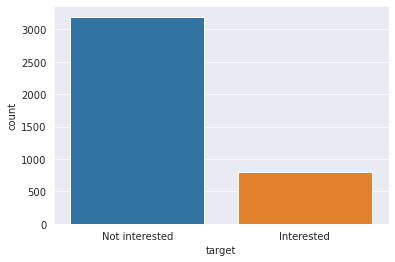

In [137]:
chart = sns.countplot(x='target',data=train_test)
_ = chart.set_xticklabels(['Not interested','Interested'])

In [138]:
count = train_csv['target'].value_counts()
value = np.round((count[1]/(count.sum()))*100,1)
print(f'The percentage of people interested in the gym memberships: {value}%'  )

The percentage of people interested in the gym memberships: 20.2%


As can be seen above, about 20% of all users are interested in the gym membership confirming the initial hypothesis that the majority of population will not be interested in the offer of the gym chain. That number coincides with the percentage of people that belong to sport groups, which makes sense considering their high correlation.

## Numerical features

I will start the analysis by taking a look at the numerical features and I will assess their usefulness for predicting the gym membership interest.

#### Age

Age can be useful for predicting gym interest since younger people tend to be more active, so they should show higher interest in the gym offer.

All of the people: mean age: 41.0, standard deviation: 13.0
The people interested in gym: mean age: 35.0, standard deviation: 12.0
The people not interested in gym: mean age: 43.0, standard deviation: 13.0


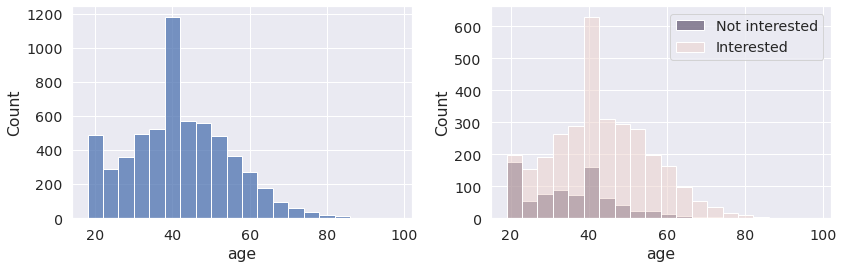

In [139]:
_,_ = utilities.draw_histplots(train_test,'age',bins=20, legend_labels=['Not interested','Interested'])

In the graph on the left we can see that the age is normally distributed with the mean around 40 years old for the whole dataset. However when we look on the graph on the right, it is possible to see that the distribution for the people interested in gym memberships is different. The mean value is about 30 years old which confirms the hypothesis that younger people are more likely to go to the gym. This clearly shows that age in negatively correlated with the taget variable and should be included in the machine learning model.

#### Location population

Location population is a continuous numerical feature but for the purposes of analysis it made more sense to group their sizes into small, medium and large bins. I would expect that people in large cities would show higher interest in gym memberships because they should typically have easier access to such facilities.

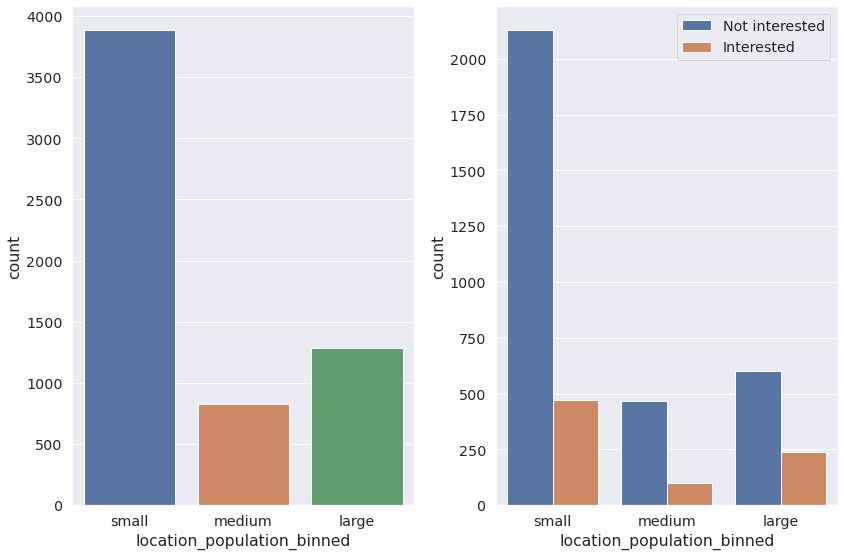

In [140]:
_,_ = utilities.draw_countplots(train_test,'location_population_binned',legend_labels=['Not interested','Interested'])

In [141]:
pd.DataFrame(train_test['location_population_binned'].value_counts())

,location_population_binned
small,3884
large,1286
medium,830


In [142]:
utilities.calculate_percentages(train_test,ntrain,'location_population_binned')

,Percentage of interested
location_population_binned,
small,18.0
medium,17.0
large,28.0


Most of the people in the dataset live in the small locations (up to 200,000 inhabitants). Much smaller group comes from the medium sized locations (up to 500,000 inhabitants) and a similarly sized group comes from large cities in Poland (more than 500,000). It can be clearly seen that people in the large polish cities show higher propensity to go to the gym, which confirms the initial hypothesis. Around 28% of the users from these locations show interest in exercising, whereas for small and medium it is only 18% and 17%, respectively. Living in the larger city can provide easier access to the gym facilities, so this could be one of the reasons for these findings. To conclude, size of the city appears to help predict interest in gym memberships and will be kept for modelling.

#### Location_from population

Same as for the previous feature, the location sizes have been grouped into small, medium and large. Similarly like for the previous feature, I would expect people from larger locations to be more interested in the gym offer.

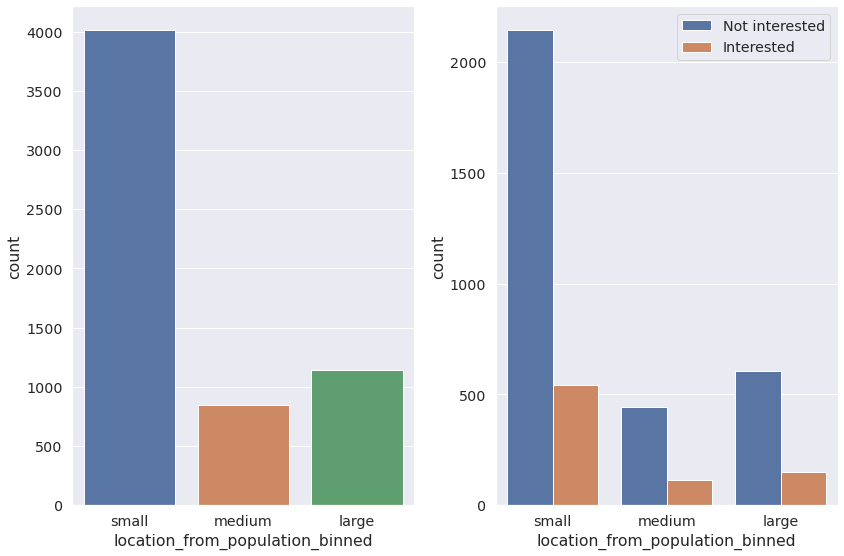

In [143]:
_,_ = utilities.draw_countplots(train_test,'location_from_population_binned',legend_labels=['Not interested','Interested'])

In [144]:
pd.DataFrame(train_test['location_from_population_binned'].value_counts())

,location_from_population_binned
small,4011
large,1142
medium,847


In [145]:
utilities.calculate_percentages(train_test,ntrain,'location_from_population_binned')

,Percentage of interested
location_from_population_binned,
small,20.0
medium,21.0
large,20.0


Location_from population overall (unlike the location population feature) does not seem to predict the gym membership interest in any way. Across all location sizes, the percentage of users interested stays on the same level, around 20%, therefore the hypothesis was wrong. Since this feature does not seem to bring any useful information about the target value, it will not be used for predictions. 

#### Daily commute

The daily commute could be a useful predictor of the gym interest. People with longer daily commutes could have less time and energy, therefore on average lowering their interest in exercising.

All of the people: mean daily_commute: 50.0, standard deviation: 27.0
The people interested in gym: mean daily_commute: 50.0, standard deviation: 28.0
The people not interested in gym: mean daily_commute: 50.0, standard deviation: 27.0


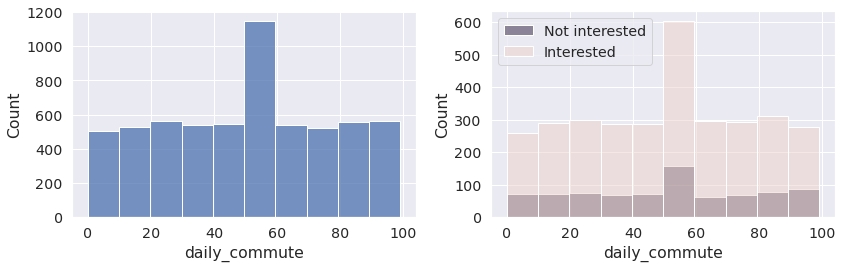

In [146]:
_,_ = utilities.draw_histplots(train_test,'daily_commute',legend_labels=['Not interested','Interested'])

The daily commute appears to be uniformly distributed for both the people interested and not interested in gym, so the probability of going to the gym is the same for all the lengths of the daily commute. That means that the initial hypothesis was wrong and this feature is of little help for the purpose of predicting that interest so it can be safely dropped.

#### Number of friends

Number of friends could be somehow correlated to the gym interest. That would be especially true if those friends would also show inclination towards gym exercising, but we unfortunately do not have that data. 

All of the people: mean friends_number: 200.0, standard deviation: 90.0
The people interested in gym: mean friends_number: 197.0, standard deviation: 41.0
The people not interested in gym: mean friends_number: 201.0, standard deviation: 99.0


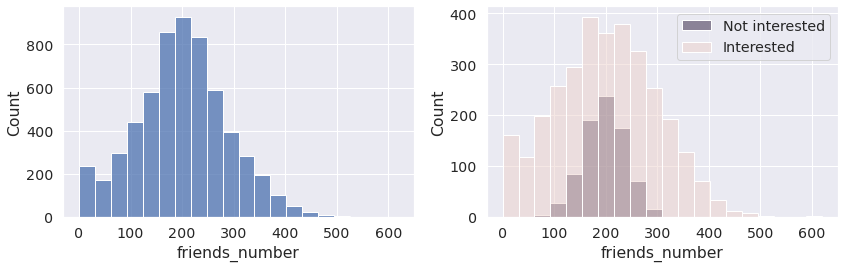

In [147]:
_,_ = utilities.draw_histplots(train_test,'friends_number',bins=20,legend_labels=['Not interested','Interested'])

Number of friends for both groups of interest is similarly distributed. On average both groups have the same number of friends, although for people not interested in gym the standard deviation is much higher. It would seem that people with very low and very high number of people show low interest in gym memberships, whereas people that have around the average amount of numbers do. That partially confirms the initial hypothesis but additional data would be neccesary to understand the reasons for such behavior.

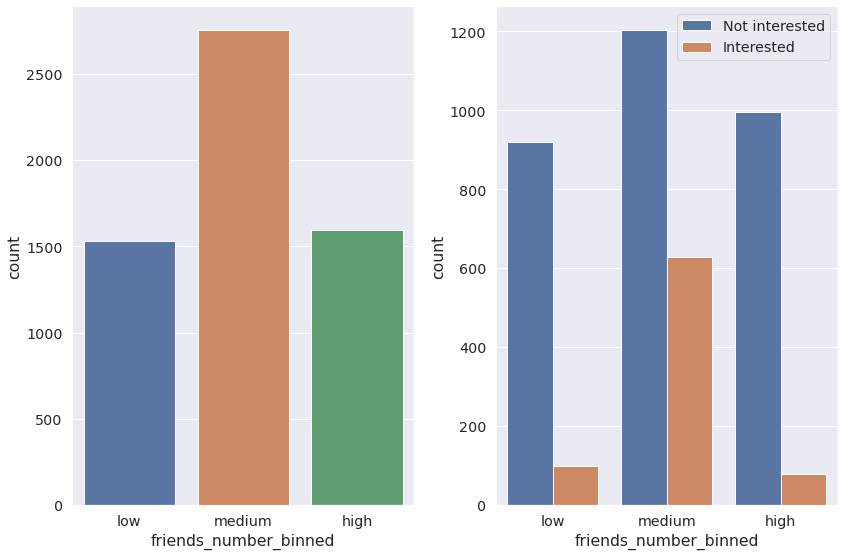

In [148]:
_,_ = utilities.draw_countplots(train_test,'friends_number_binned',legend_labels=['Not interested','Interested'])

We can clearly see that people with the average amount of friends (between 150 and 250) are much more likely to be interested in gym memberships, whereas people with less than 150 friends or more than 250 are not very likely to do the same. The fact of belonging to the medium group correlates well with the target value and, cosequently could be useful for modelling. All three of these features are highly correlated with each other so it will make most sense to keep only one of them.

## Categorical variables

In the second part of the exploraoty data analysis I will take a look at the categorical variables and their usefulness for predicting gym membership interest.

#### Sex 

The sex of a person should be a pretty good indicator of the gym interest. On average I would expect men to be more inclined to exercise than women.

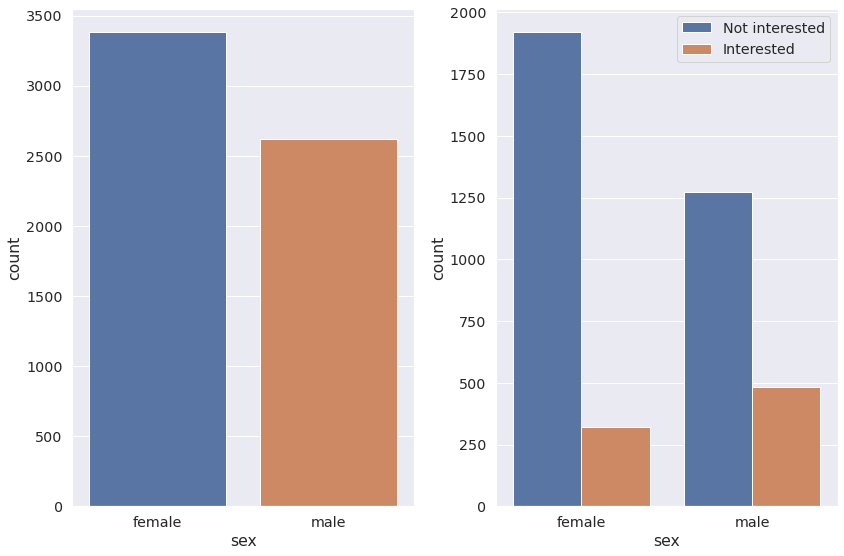

In [149]:
_,_ = utilities.draw_countplots(train_test,'sex',tick_labels = ['female','male'], legend_labels=['Not interested','Interested'])

In [150]:
utilities.calculate_percentages(train_test,ntrain,'sex')

,Percentage of interested
sex,
0,14.0
1,27.0


We can see that in the available dataset there are more women than men. Nevertheless, more men show interest in the gym membership than women, about 27% of men and only 14% of women, confirming the initial assumption. That clearly indicates that the sex of a user is a valuable feature that will be helpful for prediction purposes.

#### Occupation

Occupation could prove useful for creating the marketing strategy. People doing physical jobs could in general show more interest in further exercise than office workers.

In [151]:
unique_occupations = train_test['occupation'].nunique()
job_names = train_test['occupation'].unique()
jobs_one_hot_encoded = train_test[job_names]
print(f'There are {unique_occupations} unique occupations in the dataset.')

There are 43 unique occupations in the dataset.


In [152]:
occupation_sum = pd.DataFrame(train_test['occupation'].value_counts())
occupation_sum.describe()

,occupation
count,43.000000
mean,139.534884
std,10.872308
min,109.000000
25%,133.000000
50%,141.000000
75%,148.000000
max,159.000000


There are a total of 43 occupations that are similarly represented in the dataset, the minimum having 109 records and the maximum having 159 records.

In [153]:
# obtaining the key for ordering the occupation countplot
key = train_test[train_test['target']==1].groupby('occupation').count().sort_values('user_id',ascending=False).index

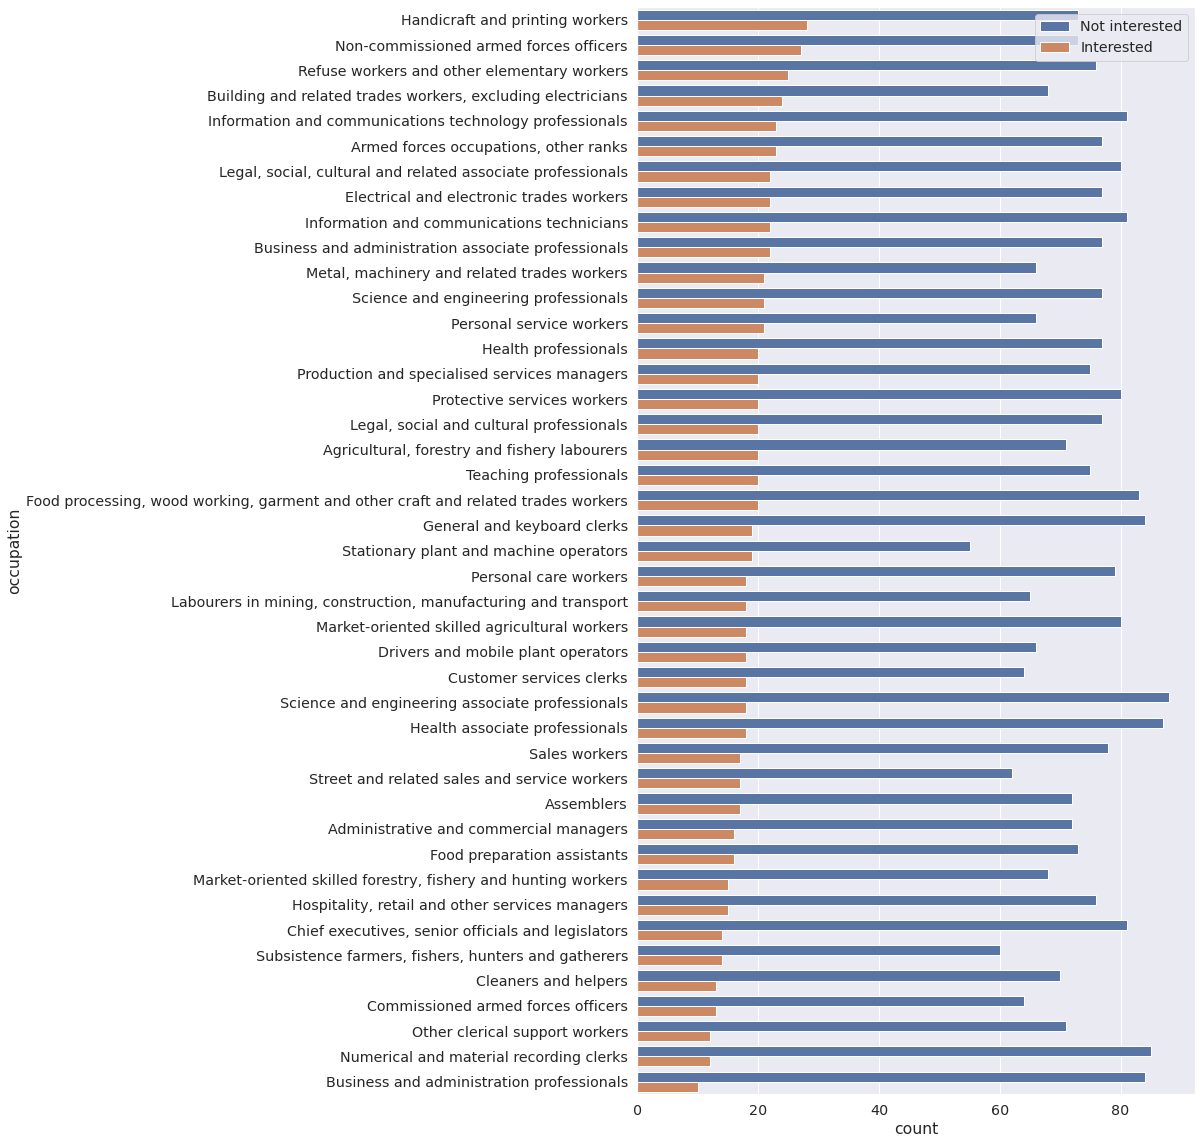

In [154]:
train_set = train_test.loc[:ntrain]
fig, axes = plt.subplots(1, 1, figsize=(10, 20))
chart = sns.countplot(y='occupation',data=train_set, hue='target', ax=axes, order=key)
chart = chart.legend(['Not interested','Interested'],loc=1)

In [155]:
utilities.calculate_percentages(train_test,ntrain,'occupation',sort=True).head(10)

,Percentage of interested
occupation,
Handicraft and printing workers,28.0
Non-commissioned armed forces officers,27.0
"Building and related trades workers, excluding electricians",26.0
Stationary plant and machine operators,26.0
Refuse workers and other elementary workers,25.0
"Metal, machinery and related trades workers",24.0
Personal service workers,24.0
"Armed forces occupations, other ranks",23.0
Information and communications technology professionals,22.0


As mentioned before, there are 43 different occupations in the provided dataset, and there are fairly significant differences between the gym interest in different groups. The lowest percentage of people interested is 11% (business and administration professionals) and the highest is 28% (handicraft and printing workers). Overall, it can be clearly seen that interest in gym memberships varies with the occupation of the person. People doing some sort of physical work or military-affiliated are more inclined towards exercisising than office workers, who show the least interest. For the purposes of the machine learning model 20 jobs will be selected: the top 10 jobs with the highest propensity and the bottom 10 with the lowest.

I will also check whether it is better to keep the selected occupation features separately or to sum them into new features. For that purpose I created two new features: sport jobs (sum of top 10 occupations) and non sport jobs (sum of bottom 10 occupations).

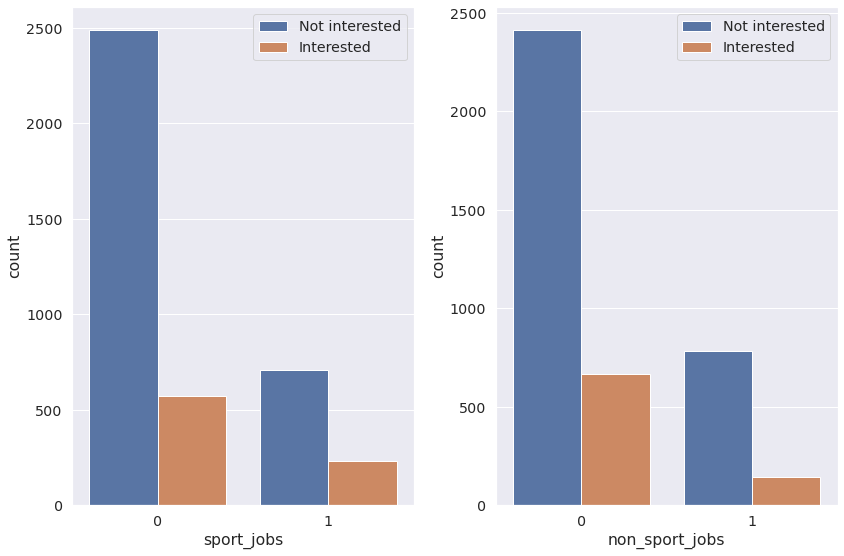

In [156]:
# sport jobs - top 10 jobs with highest percentage summed up
# non sport jobs - bottom 10 with the lowest percentage summed up
sns.set(font_scale=1.3)
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

chart1 = sns.countplot(x='sport_jobs',data=train_test, hue='target', ax=axes[0])
chart2 = sns.countplot(x='non_sport_jobs',data=train_test, hue='target', ax=axes[1])
_ = chart1.legend(['Not interested','Interested'],loc=0)
_ = chart2.legend(['Not interested','Interested'],loc=0)
    
plt.tight_layout()

In [157]:
utilities.calculate_percentages(train_test,ntrain,'sport_jobs')

,Percentage of interested
sport_jobs,
0,19.0
1,25.0


In [158]:
utilities.calculate_percentages(train_test,ntrain,'non_sport_jobs')

,Percentage of interested
non_sport_jobs,
0,22.0
1,15.0


In [159]:
print('Correlations with target:')
utilities.calculate_correlation(train_test[['sport_jobs','non_sport_jobs']],train_csv)

Correlations with target:


,Correlation with target
sport_jobs,0.062605
non_sport_jobs,-0.065886


As can be seen, 25% of people performing the top 10 jobs are interested in gym memberships whereas only 15% of the people in the bottom 10 jobs show the same interest. The correlation between the type of job and the propensity to gym exercise is not very strong, respectively around 0.06 and -0.07 but I will keep those features for now since they seem to contain some information useful for predictions.

#### Location

Both location columns have high cardinality and many locations are poorly represented in the data. For that reason, I will first select only the cities that have at least 40 users in the dataset which should leave me only with data that contains useful information. Overall, as seen before in the location population feature analysis, I expect the people from the large polish cities to show more interest in gym than people from smaller locations.

In [160]:
# getting the list of the cities with over 40 records in the dataset
location_sum = pd.DataFrame(train_test['location'].value_counts())
location_sum.columns=['Number of users']
bigger_cities = location_sum[location_sum['Number of users'] >= 40]

In [161]:
bigger_cities

,Number of users
Warszawa,521
Kraków,223
Łódź,211
Wrocław,181
Poznań,150
Gdańsk,115
Szczecin,99
Bydgoszcz,92
Lublin,85
Katowice,78


For these selected cities with a higher representation in the dataset I can calculate the percentage of people interested in gym memberships in each location.

In [162]:
# calculating the key for ordering the city countplot
w = train_test[train_test['location'].isin(bigger_cities.index)]
key = w[w['target']==1].groupby('location').count().sort_values('user_id',ascending=False).index

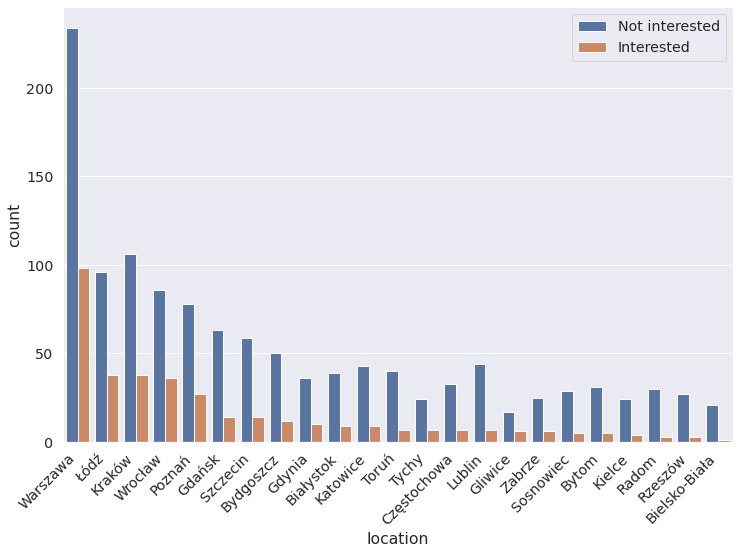

In [163]:
train_set = train_test[train_test['location'].isin(bigger_cities.index)].loc[:ntrain]
#key = bigger_cities.index
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
chart = sns.countplot(x='location',data=train_set, hue='target', ax=axes, order=key)
_ = chart.set_xticklabels(labels = chart.get_xticklabels(),rotation=45, horizontalalignment='right')
_ = chart.legend(['Not interested','Interested'],loc=0)

In [164]:
# selecting only the rows that come from the location with more than 40 records in the dataset
a = train_test[train_test['location'].isin(bigger_cities.index)]
city_percentage = utilities.calculate_percentages(a ,ntrain,'location',sort=True)

In [165]:
# temporary dataframe with the names and the number of records for each of the bigger cities
b = bigger_cities.reset_index()
b.columns = ['location','Number of users']

In [166]:
# merging two tables to show both the percentage of interest and the total number of people in the data for each location
pd.merge(city_percentage.reset_index(),b,on='location').set_index('location')

,Percentage of interested,Number of users
location,,
Wrocław,30.0,181
Warszawa,30.0,521
Łódź,28.0,211
Kraków,26.0,223
Gliwice,26.0,41
Poznań,26.0,150
Tychy,23.0,46
Gdynia,22.0,63
Zabrze,19.0,49


It can be clearly seen that the percentage of the population in the bigger polish cities (from the given dataset) that shows interest in the gym memberships is higher than in smaller locations, confirming the hypothesis. Highest interest can be seen in Wrocław and Warsaw at 30% and the lowest in Bielsko-Biała at only 5% (although it is also one of the least represented cities at 42 users). As mentioned before, only the cities that have at least 40 users in the provided dataset have been selected so that the percentage of interested people can be more meaningful (there are many locations with only 1 or 2 users so in their case it is easy to reach 100% interest in these places but that does not bring much useful information because of the small sample size).

#### Relationship status

Relationship status is fairly likely to influence the interest any given person has in gym memberships. I would expect married people to have very low interest and single people to be highly interested (for example because they may want to look more attractive).

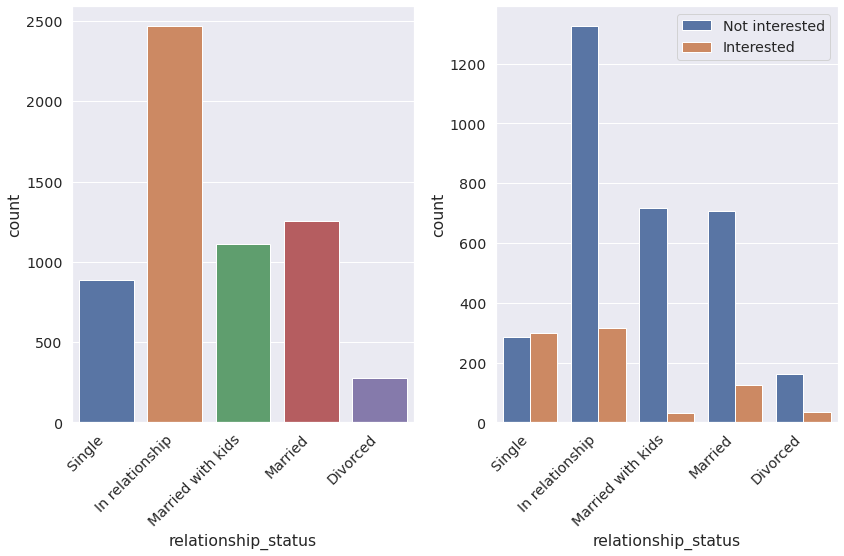

In [167]:
_,_ = utilities.draw_countplots(train_test,'relationship_status',rotate_labels=True, legend_labels=['Not interested','Interested'])

Single people appear to be the group with the highest interest in gym memberships with over 50% of them being interested. Comparatively, the group of people in relationship despite being more than twice the size of the single group, has nearly identical amount of people with propensity towards gym memberships and overall only about 15% of that group. Other groups, (married, married with kids and divorced) show very low interest. Overall, being single seems to be the best indicator here whether a given person will want to go to the gym or not which confirms the initial assumptions. This feature clearly will be useful for making predictions and therefore will be kept for modelling.

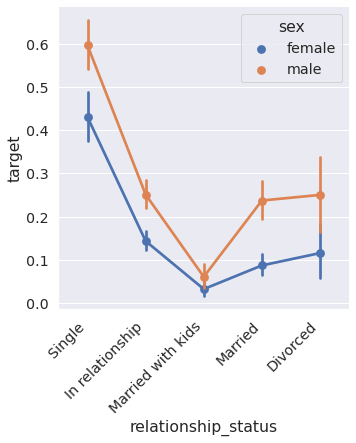

In [168]:
_ = utilities.draw_catplot(train_test,x='relationship_status',hue='sex',rot=45,legend_labels=['female','male'])

Further analysis shows that about 60% of single men show propensity towards gym. For this reason, that is the group that should be targeted the most. For other groups that percentage does not exceed 25%. Across all categories of relationship status it is possible to observe that men are more likely to go to the gym, further confirming earlier findings.

#### Interest in sport groups

Belonging to the sport related group is very likely to be highly correlated with the interest in gym memberships. The expectation is that people affiliated to such groups will show much higher interest and will be a good group to target with the marketing actions.

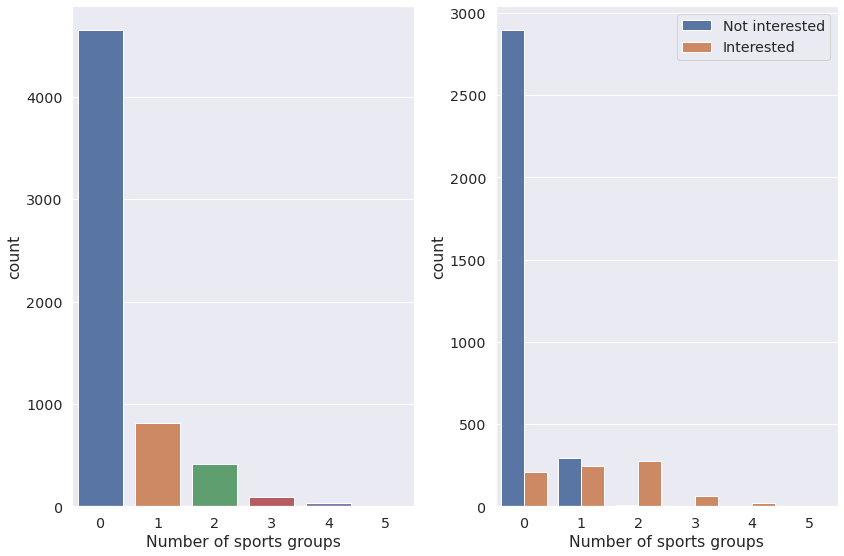

In [169]:
_,_ = utilities.draw_countplots(train_test,'sport_groups', xlabel="Number of sports groups",legend_labels=['Not interested','Interested'],legend_loc=1)

As can be seen in the graph on the left, about 80% of people do not belong to any sports groups, and the rest belongs to 1 or more. Graph on the right clearly shows that belonging to at least one sports group greatly increases the probability that a person will be interested in gym memberships, confirming the initial assumption. Only about 5% of non-affiliated people show inclination to go to the gym. For people belonging to one group that number is around 40% and among people belonging to two or more groups, all of the people in the dataset are interested in gym memberships. It has to be noted however that there are not many records in the dataset of people belonging to 2 or more sport groups, so the real interest in that group is probably lower than 100%, but fortunately that wouldn't change the general trend. Based on these findings I can conclude that the fact of belonging to a sports group is indeed highly correlated with the target variable and will be very valuable for predicting interest.

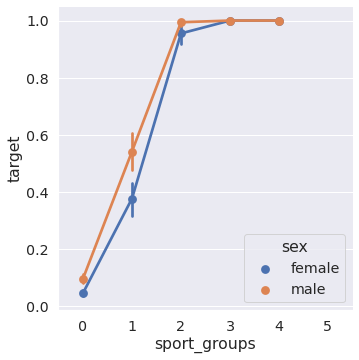

In [170]:
_ = utilities.draw_catplot(train_test,x='sport_groups',hue='sex',legend_labels=['female','male'])

On the next plot it can be clearly seen that the percentage of people interested in gym memberships grows rapidly with the number of sport groups they belong to for both men and women, further confirming that it is a very important predictor.

#### Sport related hobbies

Similarly like in the case of affiliation to sport related groups, I would expect the people with sport related hobbies to show significantly higher propensity towards gym memberships.

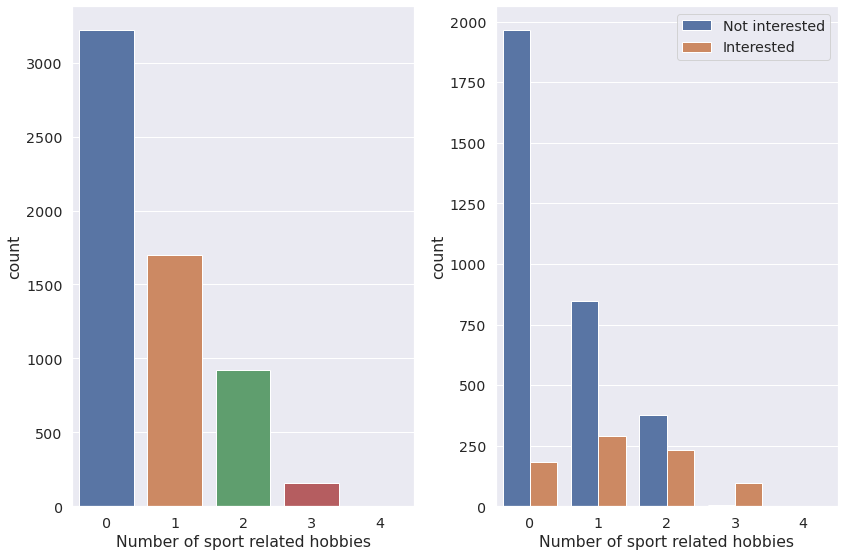

In [171]:
_,_ = utilities.draw_countplots(train_test,'sport_hobbies', xlabel="Number of sport related hobbies",legend_labels=['Not interested','Interested'],legend_loc=1)

The fact of having a sport related hobby appears to be strongly correlated with the interest in gym memberships although to a lesser extent than in case of sport groups. People with no sport related hobbies have only about 10% probability of having interest in the gym. With one such hobby that number improves to around 25% and with two hobbies to around 40%. People in the given dataset that have 3 or more sport related hobbies all show interest in the gym memberships but they are also very sparsely represented in the dataset. Clearly the number of sport related hobbies can be used to predict the gym interest and therefore will be used for modelling. 

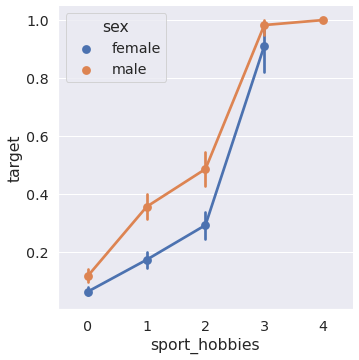

In [172]:
_ = utilities.draw_catplot(train_test,x='sport_hobbies',hue='sex',legend_labels=['female','male'])

The categorical plot clearly confirms the earlier conclusions that the percentage of people interested in gym grows very quickly with the number of sport related hobbies they have (although not as quickly as with the affiliation to sport groups)

#### Level of education

The level of education may be a useful predictor of gym interest. Highly educated people on average could be more wealthy, meaning that they could spare more time and money on staying in shape.

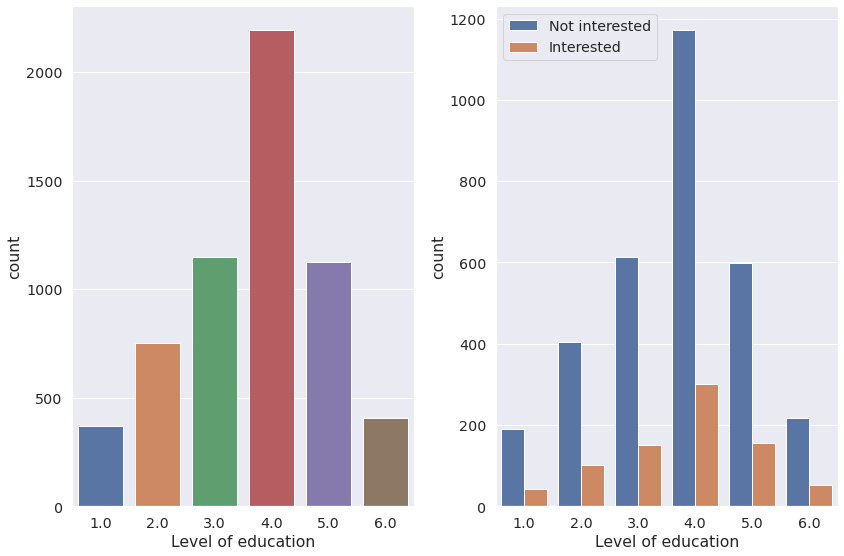

In [173]:
_,_ = utilities.draw_countplots(train_test,'education', xlabel="Level of education",legend_labels=['Not interested','Interested'])

In [174]:
utilities.calculate_percentages(train_test,ntrain,'education')

,Percentage of interested
education,
1.0,18.0
2.0,20.0
3.0,20.0
4.0,21.0
5.0,21.0
6.0,20.0


According to the left graph, the level of education follows the normal distribution and most of the users have achieved the 4th level of education. However by looking at the right graph we can see that there is no visible correlation between the level of education and the interest in gym memberships. That can be further seen if we calculate the percentages of interested people in each group. In each case the level of gym interest hovers around 20%, meaning that the level of education is not a good predictor for our target variable and the initial guess was wrong. 

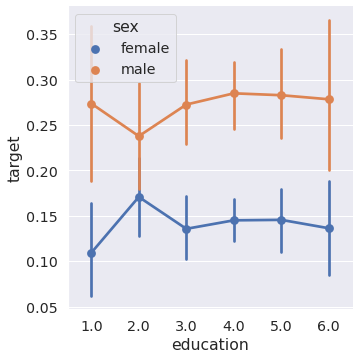

In [175]:
_ = utilities.draw_catplot(train_test,x='education',hue='sex',legend_labels=['female','male'])

In the graph above we can see that women with the 2nd level of education show higher than average interest in gym memberships and men on the same level show interest lower than average (although the difference is not very large, about 5 percentage points). Overall, this plot only confirms that the education level is not a very valuable predictor of the gym interest.

#### Credit card type

Credit card type is highly unlikely to be correlated with gym interest, unless the card providers would include some sort of benefits or target certain demographic groups (like young people for example) with their own marketing campaigns.

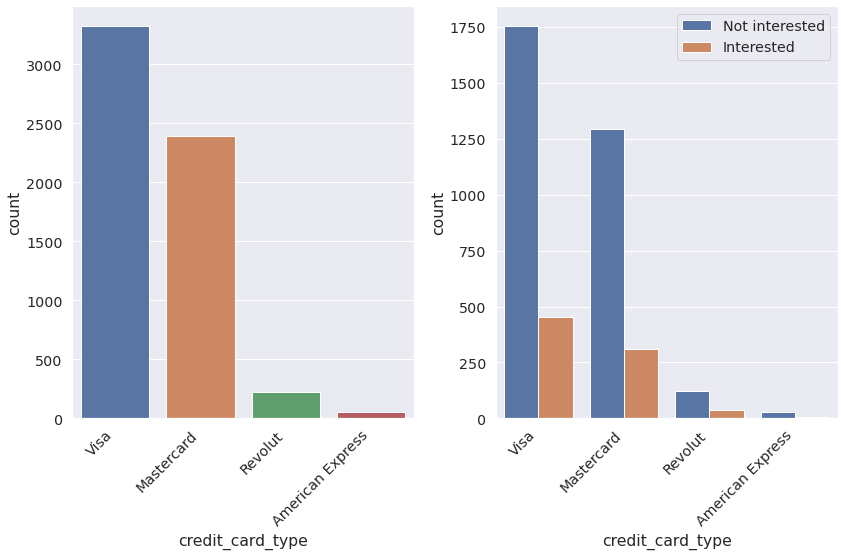

In [176]:
_,_ = utilities.draw_countplots(train_test,'credit_card_type',rotate_labels=True,legend_labels=['Not interested','Interested'])

In [177]:
utilities.calculate_percentages(train_test,ntrain,'credit_card_type')

,Percentage of interested
credit_card_type,
American Express,20.0
Mastercard,19.0
Revolut,23.0
Visa,20.0


The majority of people are using Visa and Mastercard cards, with only a small group using Revolut and American Express. However even after taking that difference in scale into account, the users of all card types still show nearly identical propensity towards gym memberships, at about 20%. That clearly confirms the initial hypothesis that credit card type is not a valuable source of information for predicting interest in gym memberships.

## Summary of the findings

The just conducted exploratory data analysis has revealed many insights about the dataset that can be invaluable for the team responsible for creating the market strategy for opening new venues. Most important findings are as follows:
* Young people (around 20 to 30 years old) show higher interest in gym memberships than older people
* Residents of large cities are more interested in exercising
* People with average number of friends show higher propensity towards gym memberships than people with number significantly below or above the average
* Men are more likely to buy a gym membership than women
* People doing physical work or affiliated to military are more likely to show interest in attending gym
* Office workers are much less likely to go to the gym
* Single people are much more likely to be interested in gym memberships, compared to other relationship statuses
* Belonging to the sport themed groups is a very strong indicator of gym interest
* Similarly, having sport related hobbies also points towards higher interest in gym memberships
* Level of education has no significant influence on gym interest

To summarize, based on these findings, the ideal client for the gym chain would be young, single men living in large cities, that belong to at least one sport themed group and having at least one sport related hobby.

# Machine learning modelling

In the last part of this report I will create a machine learning model for predicting the gym membership interest based on the features I have identified as useful in the exploratory data analysis.

In [178]:
# spliting the train and test set
train = train_test[:ntrain]
test = train_test[ntrain:]

In [179]:
# the list of features selected for modelling
selected_features = ['sex','age','sport_hobbies','sport_groups','Single','friends_number_medium',
                    'loc_large','sport_jobs','non_sport_jobs']
target = 'target'

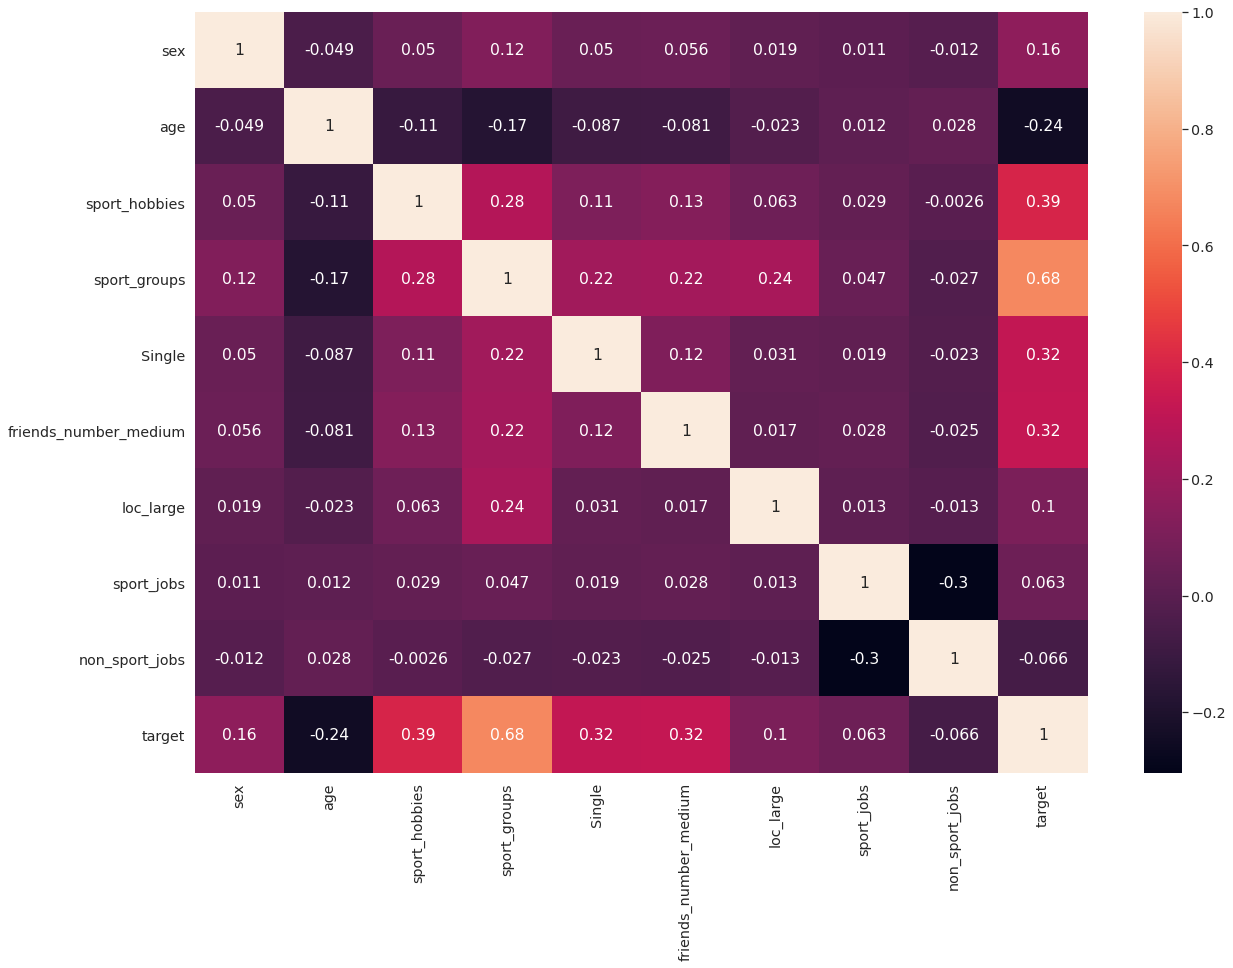

In [180]:
_ = utilities.plot_heatmap(train[selected_features+[target]],selected_features+[target],size=(20,14))

As can be seen, the selected features show significant correlation with the target variable and only limited correlation with each other, meaning that each of the selected features carries useful information and there is not much redundancy in the data which should help limit the overfitting of the model.

In [207]:
# separating the target variable and the selected features
X_train = train[selected_features]
y_train = train[target]
X_test = test[selected_features]

The choice of the right metric for assessing the model quality is a very important step towards developing a high quality model. In the case of predicting the gym interest we care much more to predict correctly the people that will actually be interested in the gym membership and minimize the amount of wrongly targeted people than correctly predicting lack of interest. For that reason I will choose the f1 score as my metric which combines both of these goals into a single number, leading to easier quality assessment. 

It is generally relatively hard to choose the best machine learning algorithm because each dataset is different and an algorithm that works great on one can be much worse on another. For that purpose I will try several algorithms on the given data set with default hyperparameters and I will assess their quality using the chosen metric (f1 score) and cross validation. Next I will pick the best performing ones and perform hyperparameter tuning to try to improve their performance further.

In [274]:
# list of the models
# MLA - machine learning algorithms
MLA = [
    # Ensemble Methods
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    
    # Linear models
    LogisticRegression(),
    PassiveAggressiveClassifier(),
    RidgeClassifier(),
    SGDClassifier(),
    Perceptron(),
    
    # Naive Bayes
    BernoulliNB(),
    GaussianNB(),
    
    # Nearest Neighbor
    KNeighborsClassifier(),
   
    # xgboost,lgbm,catboost
    XGBClassifier(), 
    LGBMClassifier(),
    CatBoostClassifier()
    ]

In [259]:
# splitting the features and the target variable
X_train = train[selected_features]
y_train = train[target]
X_test = test[selected_features]

In [275]:
# scaling the data to improve the performance of gradient based algorithms
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
MLA_compare = utilities.model_assessment(X_train,y_train,MLA)

In [302]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train f1 Score Mean,MLA Test f1 Score Mean
5,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.803683,0.803254
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.801674,0.80012
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.827098,0.794454
15,CatBoostClassifier,{},0.864923,0.787436
14,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.882206,0.778056
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.951179,0.774953
13,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.902851,0.772246
11,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.774836,0.771415
8,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.776151,0.769592
7,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.772158,0.768877


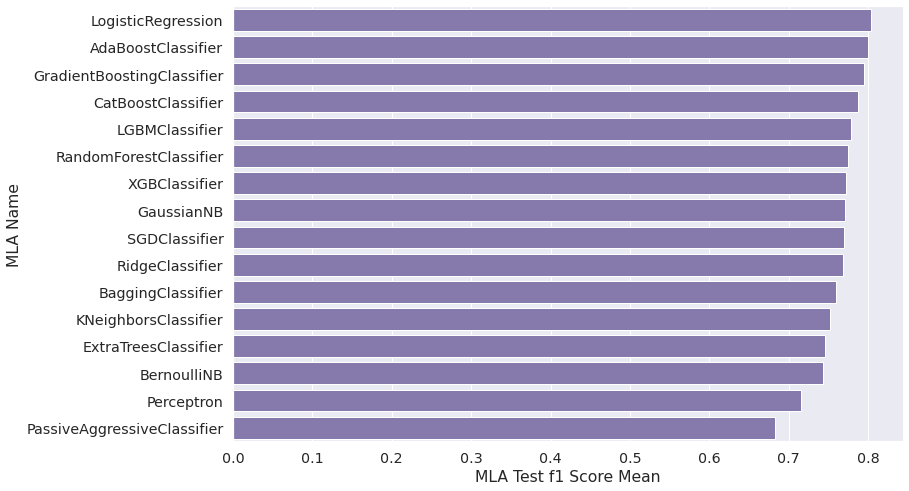

In [278]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
_ = sns.barplot(x='MLA Test f1 Score Mean',y='MLA Name',data=MLA_compare,color='m', ax=axes)

As we can see, the top 5 best performing algorithms for this data set are 
* Logistic regression
* AdaBoost classifier
* Gradient boosting classifier
* CatBoost classifier
* LGBM classifier

In the next step I will attempt to tune the hyperparameters of these models to try to improve their performance.

## Hyperparameter tuning

For finding the best hyperparameters for each model I will utilize the grid search method that checks each combination of parameters and evaluates them using cross validation.

In [288]:
top_models = [
            # Linear models
            LogisticRegression(),
    
            # Ensemble Methods
            AdaBoostClassifier(),
            GradientBoostingClassifier(),

            # lgbm,catboost
            CatBoostClassifier(),
            LGBMClassifier()
            ]

In [279]:
grid_n_estimator = [500,1000,2000,3000,4000]
grid_learn = [.01, .03, .05, .1, .25]
grid_seed = [0]

In [287]:
# parameters for the grid search for each model
grid_param = [
            [{
            #LogisticRegression 
            'fit_intercept': [True, False], 
            'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
            'random_state': grid_seed
             }],
    
    
            [{
            #AdaBoostClassifier 
            'n_estimators': grid_n_estimator, 
            'learning_rate': grid_learn, 
            'algorithm': ['SAMME', 'SAMME.R'], 
            'random_state': grid_seed
            }],


            [{
            #GradientBoostingClassifier 
            'learning_rate': grid_learn, 
            'n_estimators': grid_n_estimator,
            'max_depth': [2, 4, 6, 8, 10, None],   
            'random_state': grid_seed
             }],    
            
            [{
            #Catboost Classifier 
            'learning_rate': grid_learn,
            'rsm': [0.2,0.3,0.4,0.5,0.6], 
            'n_estimators': grid_n_estimator, 
             }], 
    
            [{
            #LGBM classifier
            'learning_rate': grid_learn,
            'n_estimators': grid_n_estimator,
            'num_leaves': [2,4,6,10,15,20,30], 
            'max_bin': [10,20,40,55,70,90],
            'bagging_fraction': [0.2,0.4,0.6,0.8,1.0],
            'bagging_freq': [1,5,10,15,20],
            'colsample_bytree': [0.2,0.4,0.6,0.8,1.0],
            'min_sum_hessian_in_leaf': [1,3,5,7,11,13,15],
            'min_data_in_leaf': [2,4,6,8,10,16],
            'random_state': grid_seed
             }]
     
        ]

In [ ]:
# running randomized search instead of grid search because full grid search takes a very long time to finish
params = []
for model,hyperparam_combs in zip(top_models,grid_param):
    clf = RandomizedSearchCV(model,
                             hyperparam_combs,
                             scoring='f1',
                             random_state=1,
                             n_iter=20)

    search = clf.fit(X_train, y_train)

    params.append(search.best_params_)

After running the grid search I will apply the results of the tuning to the selected models and assess their quality again.

In [297]:
top_models_tuned = [
            # Linear models
            LogisticRegression(fit_intercept = True, 
                                penalty = 'l1',
                                solver = 'saga',
                                random_state = 0),
    
            # Ensemble Methods
            AdaBoostClassifier(n_estimators = 4000, 
                                learning_rate = 0.01, 
                                algorithm = 'SAMME.R', 
                                random_state = 0),
    
            GradientBoostingClassifier(learning_rate = 0.03, 
                                        n_estimators = 1000, 
                                        max_depth = 2,   
                                        random_state = 0),

            # lgbm,catboost
            CatBoostClassifier(n_estimators = 500,
                               learning_rate = 0.01,
                               rsm = 0.4,
                               random_seed=0),
    
            LGBMClassifier(num_leaves=30,learning_rate=0.03, n_estimators=1000,
                              max_bin = 70, bagging_fraction = 0.8,random_state = 0,
                              bagging_freq = 1, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =2, min_sum_hessian_in_leaf = 1,colsample_bytree = 0.2)

            ]

In [ ]:
MLA_compare_tuned = utilities.model_assessment(X_train,y_train,top_models_tuned)

In [301]:
MLA_compare_tuned

,MLA Name,MLA Parameters,MLA Train f1 Score Mean,MLA Test f1 Score Mean
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.80372,0.802502
1,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.804567,0.801435
2,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.819817,0.794225
3,CatBoostClassifier,"{'learning_rate': 0.01, 'rsm': 0.4, 'random_se...",0.829005,0.79378
4,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.844522,0.780568


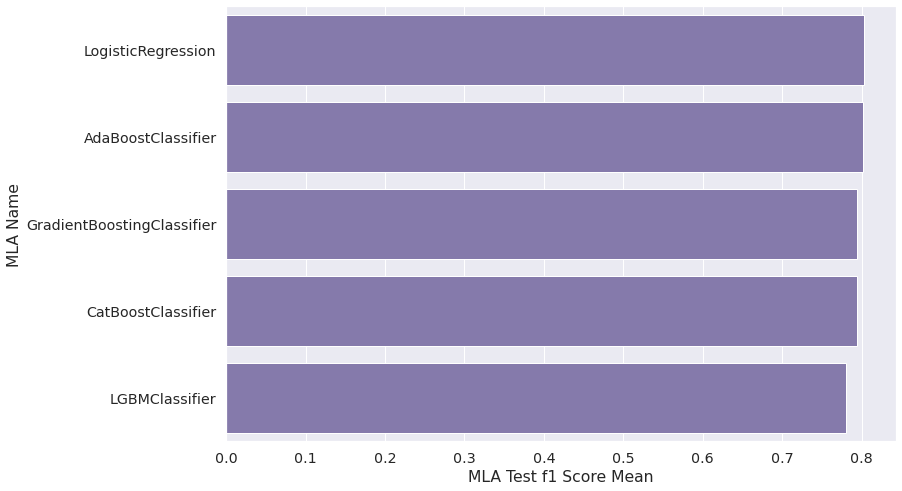

In [300]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
_ = sns.barplot(x='MLA Test f1 Score Mean',y='MLA Name',data=MLA_compare_tuned,color='m', ax=axes)

The data shows that the hyperparameter tuning has not improved the performance very significantly in this case. The differences between the default classifiers and tuned ones are very small. The reason for that may be that only the RandomizedSearchCV has been used for the tuning instead of full grid search because time and hardware constraints. Possible solution would be to conduct the full grid search which could find better parameters for each model.

## Ensemble learning

Using multiple models together usually yields better results than using just one model. For that reason I will now run cross validation on the tuned models and I will obtain their out-of-fold predictions. Then I will be able to combine these predictions into a new dataset and try predicting the target variable based on these new features.

In [ ]:
oofs_list = []
preds_list = []
for model in top_models_tuned:
    oofs,preds = utilities.get_predictions(model, train, test, selected_features, target, N_SPLITS = 5,scaling=True,fi_enable = False,fit_params={})
    oofs_list.append(oofs)
    preds_list.append(preds)

In [315]:
# creating ensemble dataset
X_train_ensemble = pd.DataFrame(oofs_list).transpose()
y_train_ensemble = y_train.copy()
X_test_ensemble = pd.DataFrame(preds_list).transpose()

In [ ]:
X_train_ensemble.head()

After creating the new dataset the performance of the best models will be compared again.

In [ ]:
MLA_compare_ensemble = utilities.model_assessment(X_train_ensemble,y_train_ensemble,top_models_tuned)

In [319]:
MLA_compare_ensemble

,MLA Name,MLA Parameters,MLA Train f1 Score Mean,MLA Test f1 Score Mean
4,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.801231,0.797954
3,CatBoostClassifier,"{'learning_rate': 0.01, 'rsm': 0.4, 'random_se...",0.810674,0.797851
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.799436,0.795217
1,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.799024,0.794529
2,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.803957,0.794239


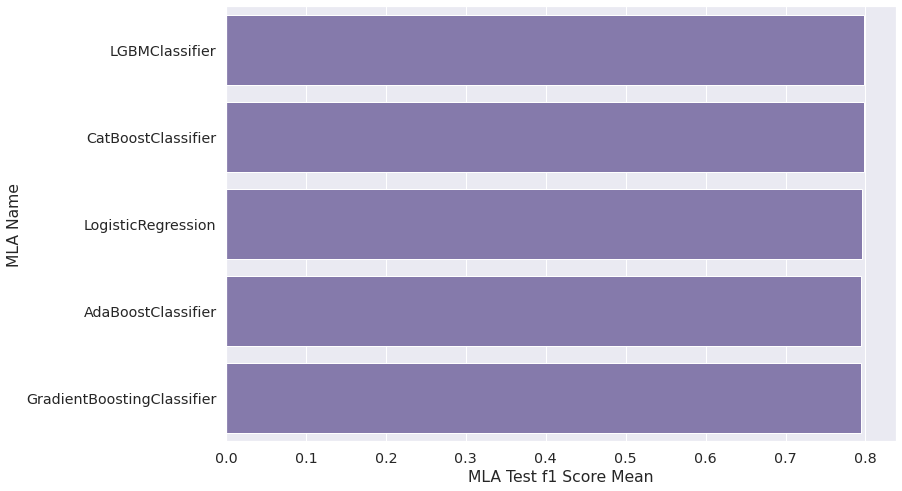

In [318]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
_ = sns.barplot(x='MLA Test f1 Score Mean',y='MLA Name',data=MLA_compare_ensemble,color='m', ax=axes)

Overall, all models performed very similarly. The differences in the mean f1 score for all of the ensemble classifiers are only marginally different. It seems that it may be neccesary to gather additional data to improve the modelling performance going forward or to engineer new features.

In [320]:
final_model = LGBMClassifier(num_leaves=30,learning_rate=0.03, n_estimators=1000,
                              max_bin = 70, bagging_fraction = 0.8,random_state = 0,
                              bagging_freq = 1, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =2, min_sum_hessian_in_leaf = 1,colsample_bytree = 0.2)

In [321]:
# parameters for fitting
fit_params = {'verbose': 300, 'early_stopping_rounds': 200}

In [ ]:
oofs_ensemble,preds_ensemble = utilities.get_predictions(final_model, train, test, selected_features, target, N_SPLITS = 5,scaling=True,fi_enable = False,fit_params=fit_params)

In [331]:
final_results = pd.DataFrame(preds_ensemble).reset_index()
final_results.columns = ['user_id','Probability_of_one']

In [333]:
positive_index = final_results[final_results['Probability_of_one']>=0.5].index

In [336]:
# setting the target to 1 if probability is higher or equal to 0.5
final_results['target'] = 0
final_results.loc[positive_index,'target'] = 1

In [344]:
print('Final results table')
final_results.head()

Final results table


,user_id,Probability_of_one,target
0,0,0.0,0
1,1,0.0,0
2,2,0.8,1
3,3,1.0,1
4,4,0.0,0


In [342]:
utilities.submit_file(final_results)